## Twitter sentiment natural language processing analysis

### Stakeholder: A marketing team at a technology company

### Business Problem Statement: 
The marketing team wants to understand consumer sentiment towards Apple and Google products. They wish to explore  emotions, and sentiments expressed by users of Apple and Google products.They need insights that can inform marketing strategies, brand perception, and customer satisfaction initiatives for their target audience.


### The main business objective is:
- What is the overall sentiment towards Apple and Google products on Twitter 

### The specific business objectives to be answered include:
- Are there any recurring themes or topics associated with positive or negative sentiments towards these brands?
- Are there any notable differences in sentiment between Apple and Google products?


### Importing the necessary packages

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package punkt to /home/pk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/pk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [27]:
df = pd.read_csv('tweet_product_company.csv', encoding='unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [28]:
df.shape

(9093, 3)

In [29]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [35]:
df.rename(columns ={'is_there_an_emotion_directed_at_a_brand_or_product' : 'sentiment', 'emotion_in_tweet_is_directed_at' : 'brand'}, inplace= True)

In [37]:
df['sentiment'] = df['sentiment'].replace('No emotion toward brand or product', 'neutral')

<AxesSubplot:xlabel='sentiment', ylabel='count'>

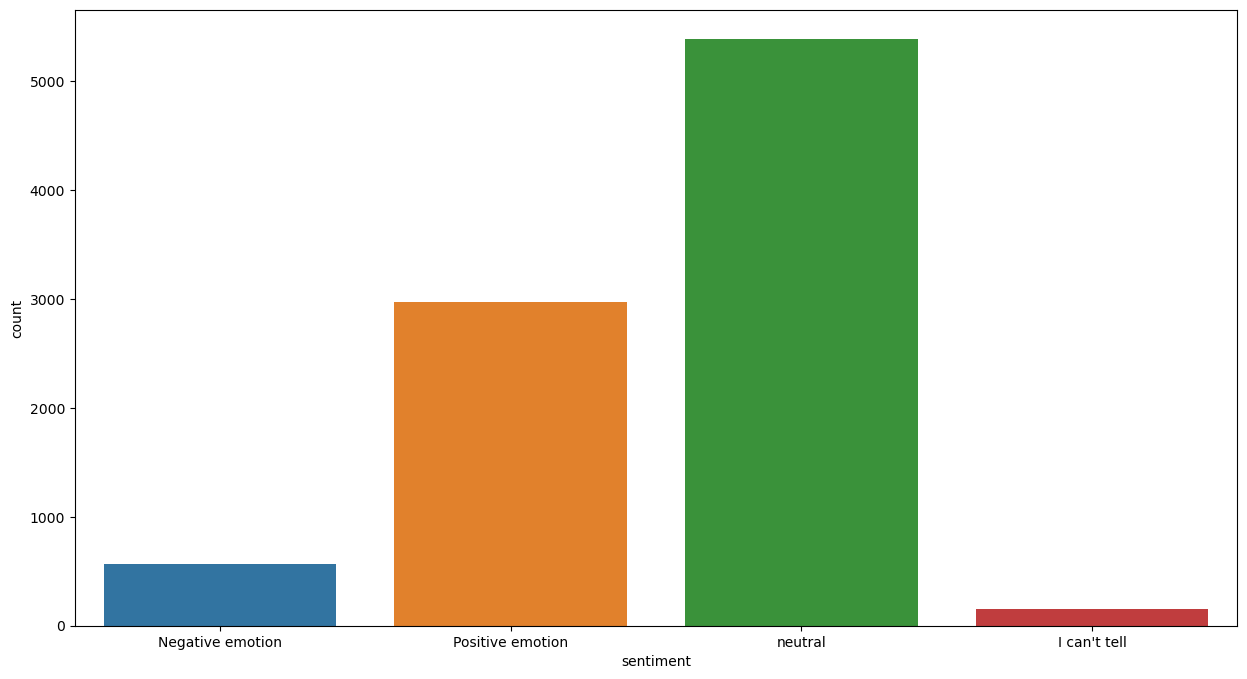

In [41]:
plt.figure(figsize = (15,8))
sns.countplot(x='sentiment', data= df)

In [44]:
df.isna().sum()

tweet_text       1
brand         5802
sentiment        0
dtype: int64

In [82]:
df['tweet_text'] = df['tweet_text'].str.lower()
df['brand'] = df['brand'].str.lower()

In [83]:
missing_brand_df = df[df['brand'].isna()]
missing_brand_df.head(10)

,tweet_text,brand,sentiment
5,@teachntech00 new ipad apps for #speechtherapy...,NaN,neutral
6,,NaN,neutral
16,holler gram for ipad on the itunes app store -...,NaN,neutral
32,"attn: all #sxsw frineds, @mention register fo...",NaN,neutral
33,anyone at #sxsw want to sell their old ipad?,NaN,neutral
34,anyone at #sxsw who bought the new ipad want ...,NaN,neutral
35,at #sxsw. oooh. rt @mention google to launch ...,NaN,neutral
37,spin play - a new concept in music discovery f...,NaN,neutral
39,vatornews - google and apple force print media...,NaN,neutral
41,hootsuite - hootsuite mobile for #sxsw ~ updat...,NaN,neutral


In [97]:
missing_brand_df.shape

(5802, 3)

In [84]:
df.brand.value_counts()

ipad                               946
apple                              661
ipad or iphone app                 470
google                             430
iphone                             297
other google product or service    293
android app                         81
android                             78
other apple product or service      35
Name: brand, dtype: int64

In [86]:
# Replace missing values with an empty string
df['tweet_text'] = df['tweet_text'].fillna('')

# Define the keywords to search for
keywords = ['apple', 'ipad or iphone app', 'google', 'iphone', 'other google product or service', 'android app', 'android', 'other apple product or service', 'ipad']

# Search for keywords in 'tweet_text' column
filtered_df = missing_brand_df[missing_brand_df['tweet_text'].str.contains('|'.join(keywords), case=False)]

In [87]:
filtered_df.head(10)

,tweet_text,brand,sentiment
5,@teachntech00 new ipad apps for #speechtherapy...,NaN,neutral
16,holler gram for ipad on the itunes app store -...,NaN,neutral
32,"attn: all #sxsw frineds, @mention register fo...",NaN,neutral
33,anyone at #sxsw want to sell their old ipad?,NaN,neutral
34,anyone at #sxsw who bought the new ipad want ...,NaN,neutral
35,at #sxsw. oooh. rt @mention google to launch ...,NaN,neutral
37,spin play - a new concept in music discovery f...,NaN,neutral
39,vatornews - google and apple force print media...,NaN,neutral
41,hootsuite - hootsuite mobile for #sxsw ~ updat...,NaN,neutral
42,hey #sxsw - how long do you think it takes us ...,NaN,neutral


In [88]:
filtered_df.shape

(5040, 3)

In [89]:
# Assign the keyword value to the 'brand' column
filtered_df['brand'] = filtered_df['tweet_text'].apply(lambda x: next((word for word in keywords if word in x), None))

/tmp/ipykernel_6642/2583434774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['brand'] = filtered_df['tweet_text'].apply(lambda x: next((word for word in keywords if word in x), None))


In [90]:
filtered_df.head(10)

,tweet_text,brand,sentiment
5,@teachntech00 new ipad apps for #speechtherapy...,ipad,neutral
16,holler gram for ipad on the itunes app store -...,ipad,neutral
32,"attn: all #sxsw frineds, @mention register fo...",android,neutral
33,anyone at #sxsw want to sell their old ipad?,ipad,neutral
34,anyone at #sxsw who bought the new ipad want ...,ipad,neutral
35,at #sxsw. oooh. rt @mention google to launch ...,google,neutral
37,spin play - a new concept in music discovery f...,ipad,neutral
39,vatornews - google and apple force print media...,apple,neutral
41,hootsuite - hootsuite mobile for #sxsw ~ updat...,iphone,neutral
42,hey #sxsw - how long do you think it takes us ...,iphone,neutral


In [91]:
filtered_df.shape

(5040, 3)

In [92]:
filtered_df.isna().sum()

tweet_text    0
brand         0
sentiment     0
dtype: int64

- missing_brand_df= 5802
- filtered_df = 5040


In [100]:
# Convert the relevant columns to sets
missing_brand_set = set(tuple(x) for x in missing_brand_df.to_numpy())
filtered_set = set(tuple(x) for x in filtered_df.to_numpy())

# Find the rows in missing_brand_df not in filtered_df
result_set = missing_brand_set - filtered_set

# Convert the resulting set back to a DataFrame
result_df = pd.DataFrame(list(result_set), columns=missing_brand_df.columns)

# Display the resulting DataFrame
result_df.head(10)

,tweet_text,brand,sentiment
0,que???? porque?!?!\n#google to launch major ne...,NaN,neutral
1,best thing abt @mention for #sxsw? proper coc...,NaN,neutral
2,go here on your iphone to get txts of the 5 be...,NaN,neutral
3,i just had to read tv recaps online to keep up...,NaN,neutral
4,ipad 2 for sale (cc #sxsw #sxswi #theinternet)...,NaN,neutral
5,n25: night of the living dead {link} [codes va...,NaN,neutral
6,your iphone? ;-) rt @mention can you find the ...,NaN,neutral
7,people in this session are taking photos with ...,NaN,neutral
8,"argh, the ux meet up is at the exact same time...",NaN,neutral
9,anyone at #sxsw know if the apple store has ha...,NaN,neutral


In [101]:
result_df.shape

(5774, 3)